<a href="https://colab.research.google.com/github/vmpreciado/NETS3120/blob/main/FBClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering in a Facebook Ego Network

In this notebook we analyze a **small subgraph of the Facebook friendship network** and study **clustering coefficients**, which quantify **transitivity** in social networks (the idea that *friends of friends are likely to be friends*).

By the end of this notebook, you should be able to:
1. Load an undirected Facebook graph and compute basic statistics.
2. Compute and interpret the **local clustering coefficient** $C(i)$ for individual nodes.
3. Compute and interpret the **global clustering coefficient** $C(\mathcal G)$ for the entire graph.
4. Visualize how clustering varies across nodes (histograms and scatter plots).

> **Note:** Although “clustering” can also refer to *community detection*, the focus of this notebook is **clustering coefficients** (triangle-based transitivity), not clustering algorithms such as k-means.

## Loading the Facebook Ego Network
### From Raw Data to a Graph Object

We begin by loading a **small Facebook friendship network** into our Python environment.

In this dataset:
- **nodes** represent Facebook users,
- **edges** represent mutual friendships.

The data is stored as an **edge list**, where each line contains two user IDs
indicating a friendship. We will load this file directly from a **public GitHub
repository**, ensuring that this notebook is fully reproducible. Once the graph is loaded, we will perform basic sanity checks to confirm that the network was imported correctly.

In [1]:
import networkx as nx
import urllib.request
from pathlib import Path

# ------------------------------------------------------------
# Load the Facebook edge list from GitHub (self-contained)
# ------------------------------------------------------------

DATA_URL = "https://raw.githubusercontent.com/vmpreciado/DS4CN/main/FacebookSmall.txt"
LOCAL_FILE = Path("FacebookSmall.txt")

def looks_like_html(path: Path, nbytes: int = 200) -> bool:
    """Heuristic: check whether a file starts like an HTML page."""
    try:
        head = path.read_text(encoding="utf-8", errors="ignore")[:nbytes].lower()
    except Exception:
        return False
    return ("<!doctype" in head) or ("<html" in head)

# Download (or re-download if the file is missing or looks wrong)
need_download = (not LOCAL_FILE.exists()) or looks_like_html(LOCAL_FILE)

if need_download:
    if LOCAL_FILE.exists():
        print("Local file exists but appears to be HTML. Re-downloading the raw dataset...")
    else:
        print("Downloading Facebook edge list from GitHub...")
    urllib.request.urlretrieve(DATA_URL, LOCAL_FILE)
    print(f"Download completed: {LOCAL_FILE.resolve()}")
else:
    print(f"Using local file: {LOCAL_FILE.resolve()}")

# Quick preview of the first few lines (sanity check)
print("\nFirst 5 lines of the file:")
with LOCAL_FILE.open("r", encoding="utf-8", errors="ignore") as f:
    for _ in range(5):
        print("  ", f.readline().rstrip())

# Load the graph (undirected friendship network)
FB = nx.read_edgelist(
    LOCAL_FILE,
    create_using=nx.Graph(),
    nodetype=int
)

print("\nFacebook graph loaded successfully.")
print(f"  nodes: {FB.number_of_nodes():,}")
print(f"  edges: {FB.number_of_edges():,}")
print(f"  directed?: {FB.is_directed()}")

Using local file: /Users/victormpreciado/Library/Application Support/JetBrains/DataSpell2025.1/projects/workspace/FacebookSmall.txt

First 5 lines of the file:
   0 1
   0 2
   0 3
   0 4
   0 5

Facebook graph loaded successfully.
  nodes: 4,039
  edges: 88,234
  directed?: False


## Local Clustering Coefficients (From Scratch)

We now compute the **local clustering coefficient** for every node in the Facebook graph.

Recall the definition for an undirected simple graph:

- Let $d_i$ be the degree of node $i$.
- The number of possible edges among the neighbors of $i$ is
  $\binom{d_i}{2}$.
- Let $\mathrm{NCP}(i)$ be the number of **connected neighbor pairs**
  (i.e., the number of edges among the neighbors of $i$).

Then the local clustering coefficient is:

$C(i) = \frac{\mathrm{NCP}(i)}{\binom{d_i}{2}}$.

By convention, if $d_i < 2$ (degree 0 or 1), we set $C(i)=0$.

In [2]:
import networkx as nx
import numpy as np

# ------------------------------------------------------------
# Compute local clustering coefficients from scratch
# ------------------------------------------------------------

def local_clustering_from_scratch(G):
    """
    Compute local clustering coefficients C(i) for an undirected simple graph G.

    For each node i:
      - neighbors = N(i)
      - NPN(i) = number of pairs of neighbors = choose(deg(i), 2)
      - NCP(i) = number of connected pairs among neighbors (edges in induced subgraph on N(i))
      - C(i) = NCP(i) / NPN(i) if NPN(i)>0 else 0
    """
    C = {}
    for i in G.nodes():
        neighbors = list(G.neighbors(i))
        d = len(neighbors)

        # If fewer than 2 neighbors, no possible triangle can exist
        if d < 2:
            C[i] = 0.0
            continue

        # Number of possible neighbor-neighbor edges
        npn = d * (d - 1) / 2  # choose(d,2)

        # Count edges among neighbors (connected pairs)
        # Induced subgraph on neighbors:
        induced = G.subgraph(neighbors)
        ncp = induced.number_of_edges()

        C[i] = ncp / npn

    return C

clustering_manual = local_clustering_from_scratch(FB)

# Quick sanity check: show a few values
sample_nodes = list(FB.nodes())[:5]
print("Manual local clustering coefficients (sample):")
for node in sample_nodes:
    print(f"  node {node}: C(i) = {clustering_manual[node]:.4f}")
print("... the list continues ...")


Manual local clustering coefficients (sample):
  node 0: C(i) = 0.0420
  node 1: C(i) = 0.4191
  node 2: C(i) = 0.8889
  node 3: C(i) = 0.6324
  node 4: C(i) = 0.8667
... the list continues ...


### Sanity check (local view)

To build intuition, we will inspect a few nodes:

- their degree $d_i$,
- the number of possible neighbor pairs $\binom{d_i}{2}$,
- the number of actual edges among neighbors (connected pairs),
- and the resulting $C(i)$.

This helps verify that the definition matches the computation.

In [3]:
def inspect_node_clustering(G, node):
    neighbors = list(G.neighbors(node))
    d = len(neighbors)

    if d < 2:
        return {
            "node": node,
            "degree": d,
            "NPN": 0,
            "NCP": 0,
            "C(i)": 0.0
        }

    npn = d * (d - 1) / 2
    induced = G.subgraph(neighbors)
    ncp = induced.number_of_edges()
    ci = ncp / npn

    return {
        "node": node,
        "degree": d,
        "NPN": int(npn),
        "NCP": int(ncp),
        "C(i)": ci
    }

# Pick a few nodes: some low degree and some higher degree if available
nodes_to_check = list(FB.nodes())[:10]

print("Intermediate quantities for selected nodes:")
for v in nodes_to_check[:5]:
    info = inspect_node_clustering(FB, v)
    print(f"  node {info['node']}: degree={info['degree']}, NPN={info['NPN']}, NCP={info['NCP']}, C(i)={info['C(i)']:.4f}")
print("... the list continues ...")

Intermediate quantities for selected nodes:
  node 0: degree=347, NPN=60031, NCP=2519, C(i)=0.0420
  node 1: degree=17, NPN=136, NCP=57, C(i)=0.4191
  node 2: degree=10, NPN=45, NCP=40, C(i)=0.8889
  node 3: degree=17, NPN=136, NCP=86, C(i)=0.6324
  node 4: degree=10, NPN=45, NCP=39, C(i)=0.8667
... the list continues ...


## Comparing With NetworkX (Validation)

NetworkX provides a one-line function `nx.clustering(G)` that returns the local clustering coefficient for each node.

We now compare our **manual implementation** against NetworkX to validate correctness.

In [4]:
clustering_nx = nx.clustering(FB)

# Compute maximum absolute error over nodes
errors = [abs(clustering_manual[v] - clustering_nx[v]) for v in FB.nodes()]
max_error = max(errors)
mean_error = sum(errors) / len(errors)

print("Comparison with NetworkX:")
print(f"  max |C_manual - C_nx|  = {max_error:.6e}")
print(f"  mean |C_manual - C_nx| = {mean_error:.6e}")

# Show a few sample comparisons
print("\nSample node comparisons:")
for v in list(FB.nodes())[:5]:
    print(f"  node {v}: manual={clustering_manual[v]:.4f}, networkx={clustering_nx[v]:.4f}")

Comparison with NetworkX:
  max |C_manual - C_nx|  = 0.000000e+00
  mean |C_manual - C_nx| = 0.000000e+00

Sample node comparisons:
  node 0: manual=0.0420, networkx=0.0420
  node 1: manual=0.4191, networkx=0.4191
  node 2: manual=0.8889, networkx=0.8889
  node 3: manual=0.6324, networkx=0.6324
  node 4: manual=0.8667, networkx=0.8667


## Average Clustering Coefficient

The **average clustering coefficient** of the graph is the mean value of $C(i)$ over all nodes.

We compute it:
1. from our manual list of values, and
2. using the one-line NetworkX function `nx.average_clustering(G)`.

In [5]:
manual_values = np.array(list(clustering_manual.values()), dtype=float)
avg_manual = manual_values.mean()

avg_nx = nx.average_clustering(FB)

print("Average clustering coefficient:")
print(f"  manual average:   {avg_manual:.6f}")
print(f"  networkx average: {avg_nx:.6f}")

Average clustering coefficient:
  manual average:   0.605547
  networkx average: 0.605547


## Histogram of Local Clustering Coefficients

Finally, we visualize the distribution of $C(i)$ across nodes.
This shows how transitivity varies from one part of the network to another.

Reminder: nodes with degree 0 or 1 have $C(i)=0$ by convention.

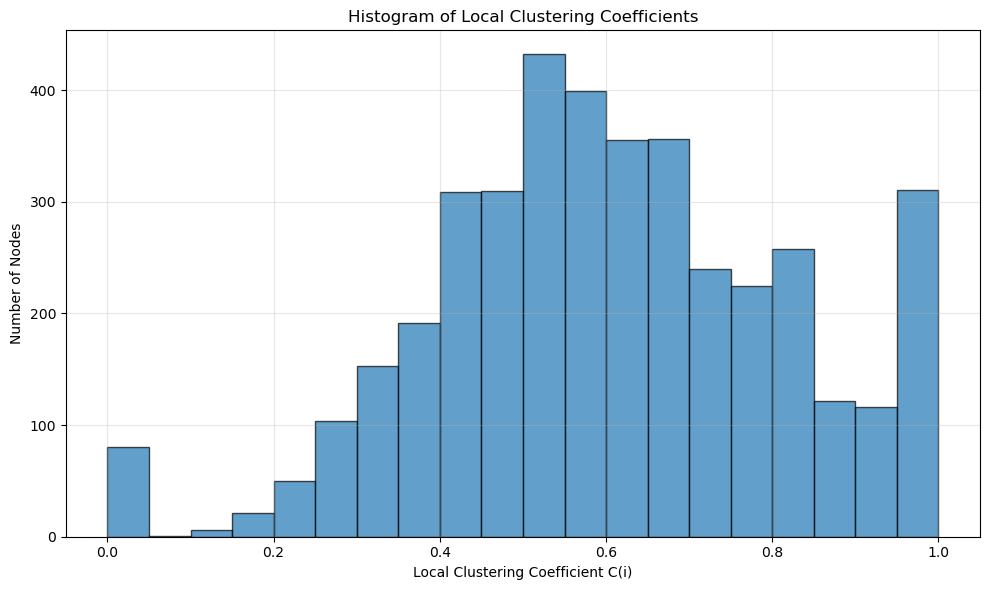

Average clustering coefficient (manual): 0.605547


In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(manual_values, bins=20, edgecolor="black", alpha=0.7)

plt.title("Histogram of Local Clustering Coefficients")
plt.xlabel("Local Clustering Coefficient C(i)")
plt.ylabel("Number of Nodes")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average clustering coefficient (manual): {avg_manual:.6f}")

### Interpreting the Histogram and the Average Clustering Coefficient

The average clustering coefficient in this Facebook subgraph is **high**
(approximately **0.60**), indicating a strong level of **local transitivity**.

This suggests that the subgraph we are analyzing is part of a
**tightly knit social community**, rather than a random collection of users.

An average clustering coefficient of **0.60** can be interpreted as follows:

> For a randomly chosen node, the probability that two of its randomly chosen
> friends are also friends with each other is approximately **60%**.

Such values are typical of real social networks, where friendships tend to form
in groups and communities, and are **much larger** than what would be expected
in a random graph with the same number of nodes and edges.

## Global Clustering Coefficient (Transitivity)

The **global clustering coefficient** $C(\mathcal G)$ measures transitivity at the *graph level*.

One standard definition (also called **transitivity**) is:

- Let $T$ be the number of triangles in the graph.
- Let $\Lambda$ be the number of wedges (paths of length 2).

Then
$C(\mathcal G) = \frac{3T}{\Lambda}$.

Interpretation: $C(\mathcal G)$ is the fraction of wedges that are “closed” into triangles.

We will compute $T$ and $\Lambda$ **from scratch**, then compare our result with NetworkX.

In [7]:
import networkx as nx
import numpy as np

# ------------------------------------------------------------
# Global clustering coefficient from scratch: C(G) = 3T / Lambda
# ------------------------------------------------------------

# Degrees
deg = dict(FB.degree())

# Wedges: Lambda = sum_i choose(d_i, 2)
Lambda = sum(d * (d - 1) // 2 for d in deg.values())

# Triangles:
# For each node i, the number of triangles incident to i equals
# the number of edges among neighbors of i, i.e., NCP(i).
# We can reuse the same induced-subgraph counting approach used for local clustering.
triangle_incident_sum = 0  # sum over nodes of (number of triangles incident to node)

for i in FB.nodes():
    neighbors = list(FB.neighbors(i))
    if len(neighbors) < 2:
        continue
    triangle_incident_sum += FB.subgraph(neighbors).number_of_edges()

# Each triangle is counted at each of its 3 vertices, so:
T = triangle_incident_sum / 3

# Global clustering coefficient (transitivity)
C_global_manual = (3 * T / Lambda) if Lambda > 0 else 0.0

print("Global clustering coefficient from scratch:")
print(f"  Triangles (T):              {int(T):,}")
print(f"  Wedges (Λ):                 {Lambda:,}")
print(f"  C(G) = 3T/Λ:                {C_global_manual:.6f}")

Global clustering coefficient from scratch:
  Triangles (T):              1,612,010
  Wedges (Λ):                 9,314,849
  C(G) = 3T/Λ:                0.519174


## Interpreting the Global Clustering Coefficient

From the computation above, we obtained:

- Number of triangles: **$T = 1{,}612{,}010$**
- Number of wedges (paths of length 2): **$\Lambda = 9{,}314{,}849$**
- Global clustering coefficient: **$C(\mathcal G) \approx 0.52$**

The global clustering coefficient measures the **fraction of wedges that are closed
into triangles**. In this network, a value of approximately **0.52** means that:

> Roughly **52% of all “friend-of-a-friend” relationships are closed**, i.e.,
> two individuals who share a common friend are themselves friends about half
> of the time.

This is an exceptionally high level of transitivity and is characteristic of
**social networks with strong community structure**.

## Validation Against NetworkX

NetworkX provides the global clustering coefficient under the name **transitivity**:

- `nx.transitivity(FB)` returns $C(\mathcal G)$ computed as $3T/\Lambda$.

We now compare our from-scratch implementation to the NetworkX result.

In [8]:
C_global_nx = nx.transitivity(FB)

print("Comparison with NetworkX:")
print(f"  Manual C(G):   {C_global_manual:.6f}")
print(f"  NetworkX C(G): {C_global_nx:.6f}")

Comparison with NetworkX:
  Manual C(G):   0.519174
  NetworkX C(G): 0.519174


## Summary: Clustering Coefficients in Social Networks

In this notebook, we studied **clustering coefficients** as quantitative measures of
**transitivity** in a real Facebook friendship network.

### Local vs. global clustering
- **Local clustering coefficient** $C(i)$ is a *node-level* measure:
  it describes how interconnected the neighbors of a specific node are.
  It captures **heterogeneity** across the network—different nodes can have
  very different clustering behavior.
- **Global clustering coefficient** $C(\mathcal G)$ is a *graph-level* measure:
  it summarizes the overall tendency of the network to form triangles by
  measuring the fraction of wedges that are closed.

### Key takeaway
Local clustering tells us **where** transitivity occurs in the network,
while global clustering tells us **how much** transitivity exists overall.